In [1]:
#https://emcee.readthedocs.io/en/stable/tutorials/line/

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();

<Figure size 432x288 with 0 Axes>

In [3]:
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [4]:
def ansatz(theta, x):
    m, b = theta
    return b + m*x

In [5]:
import numpy as np
np.random.seed(123)

# 3 lines
# pass data as either
# i) all 3 lines together
# ii) pick one line and compute error bars

# we assume there is a base-line (underlying ground truth)
# and we have 3 measurments (i.e. simulations) which are contaminated by
# "noise" e.g. numerical error due to lack of resolution or otherwise systematic error


# parameters for ground truth
m_gt = 1.2
b_gt = 2.5
# we assume the ground truth has zero noise because it is the solution of a differential equation

# data for ground truth
x_gt = np.linspace(0, 1, 200)
y_gt = ansatz([m_gt, b_gt], x_gt)


# generate 'observations' based on the ground truth

#data for observations
# n_samples = 30
n_samples = 100
idx_obs = np.random.choice(np.arange(len(x_gt)), n_samples, replace=False)
x_obs = x_gt[idx_obs]


# observed parameters are perturbations of ground truth parameters
n_sims = 3
m_obs=[]
b_obs=[]
y_obs=[]
# variable noise for each sim to simulate that different simulations have a different accuracy
noise=[1, 0.05,  0.01]
# noise=[0.001,0.001,0.001]
assert len(noise) == n_sims
for i in range(n_sims):
    m_obs_ = m_gt + np.random.normal(0, noise[i])
    b_obs_ = b_gt + np.random.normal(0, noise[i])
    y_obs_ = ansatz([m_obs_, b_obs_], x_obs)
    
    # y_obs_ += 0.001*np.random.randn(len(idx_obs))
    # y_obs_[:15] += 1*np.random.randn(len(y_obs_[:15]))
    
    m_obs.append(m_obs_)
    b_obs.append(b_obs_)
    y_obs.append(y_obs_)

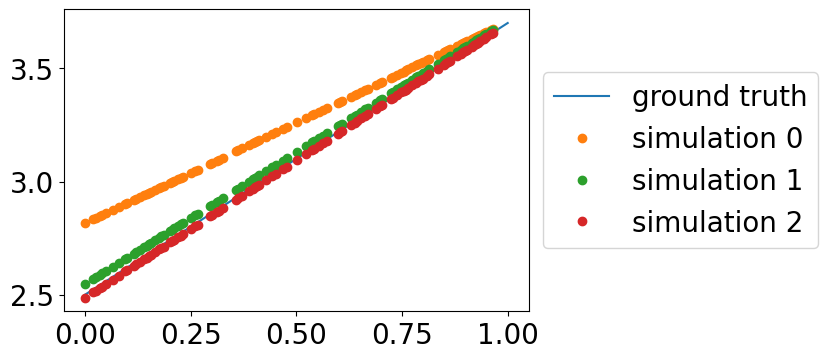

In [6]:
plt.plot(x_gt, y_gt, '-', label='ground truth')
for i, y_obs_ in enumerate(y_obs):
    plt.plot(x_obs, y_obs_, 'o', label=f'simulation {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
# in an ideal world, each observation would have their own error bars
# but we don't have this for NR

# instead we estimate the error by looking at the variance of the observations

# one method to analyse the data
# is to compute the mean of the observations as the target and
# the variance as the uncertainty

In [8]:
def est_gt_noise(y_obs):
    y = np.r_[y_obs].copy()
    gt_noise = y.std(0)
    return np.median(gt_noise)

In [9]:
gt_noise = est_gt_noise(y_obs)
gt_noise

0.06755443123596161

In [10]:
x = x_obs.copy()
y = np.r_[y_obs].copy()
# y = y.mean(0)
# yerr = y.std(0)

x = np.tile(x, n_sims)
y = np.concatenate(y)


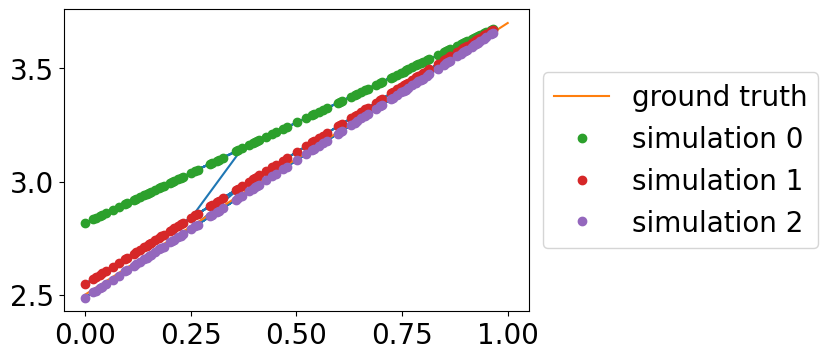

In [11]:
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y)
plt.plot(x_gt, y_gt, '-', label='ground truth')
for i, y_obs_ in enumerate(y_obs):
    plt.plot(x_obs, y_obs_, 'o', label=f'simulation {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [759]:
from scipy.optimize import curve_fit

In [760]:
f = lambda x, m, b: ansatz([m, b], x)
popt, pcov = curve_fit(f, x, y)

In [761]:
popt

array([1.08816069, 2.61660172])

In [762]:
pcov

array([[ 2.59299130e-04, -1.31486812e-04],
       [-1.31486812e-04,  8.94139713e-05]])

In [100]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    # sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    sigma2 = np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [32]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 5 and -10 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [33]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [766]:
import emcee

pos = np.concatenate([popt, [-2]]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2204.41it/s]


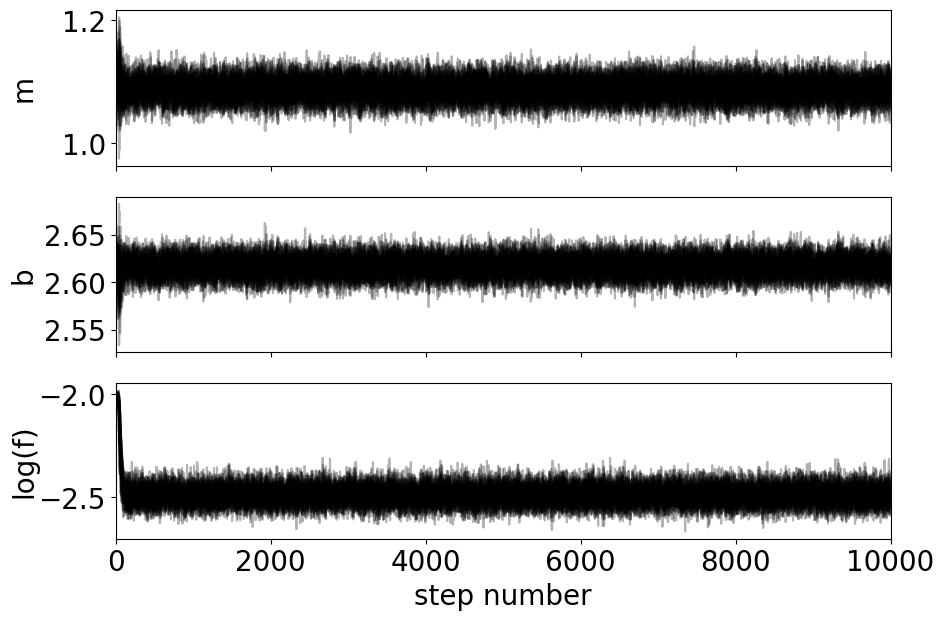

In [767]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [768]:
samples.shape

(10000, 32, 3)

In [769]:
tau = sampler.get_autocorr_time()
print(tau)

[39.05948593 39.15005978 56.31773936]


In [770]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
print(flat_samples.shape)

(25600, 3)


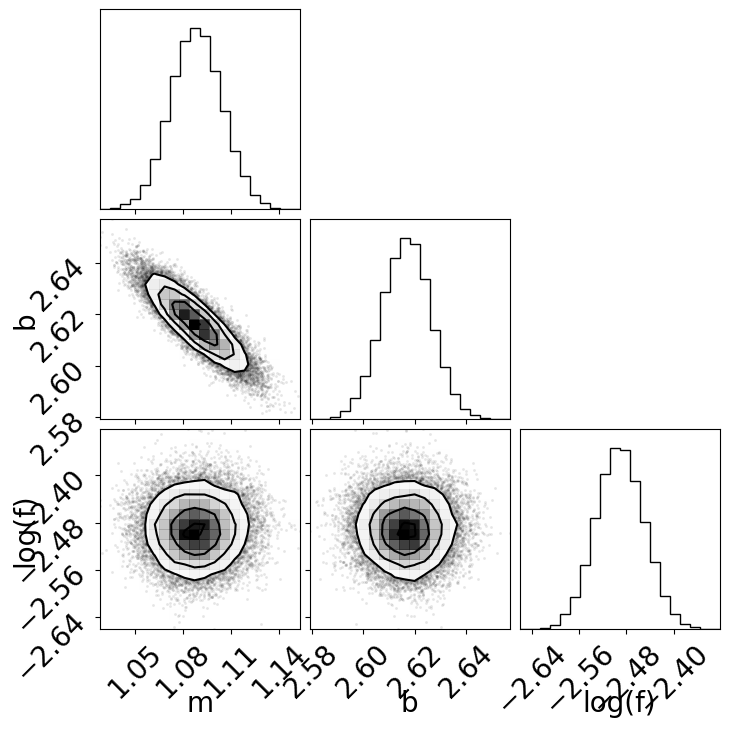

In [771]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_gt, b_gt, np.log(gt_noise)]
);

In [772]:
flat_samples[0]

array([ 1.08069398,  2.62608316, -2.44417053])

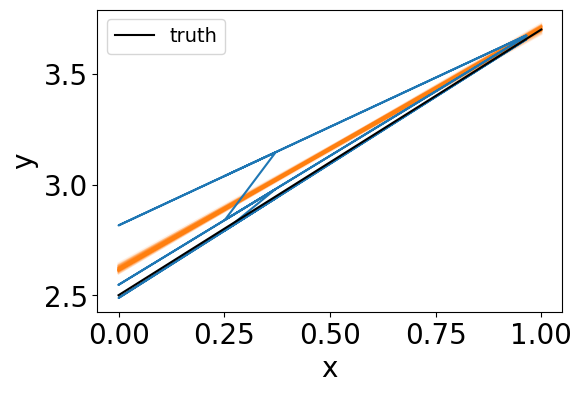

In [773]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_gt, ansatz(sample[:2], x_gt), "C1", alpha=0.1)
plt.plot(x, y)
plt.plot(x_gt, y_gt, "k", label="truth")
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [774]:
# inds = np.random.randint(len(flat_samples), size=100)
# for ind in inds:
#     sample = flat_samples[ind]
#     plt.plot(x_gt, ansatz(sample[:2], x_gt) + np.random.normal(0, yerr), "C1", alpha=0.1)
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x_gt, y_gt, "k", label="truth")
# plt.legend(fontsize=14)
# # plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");

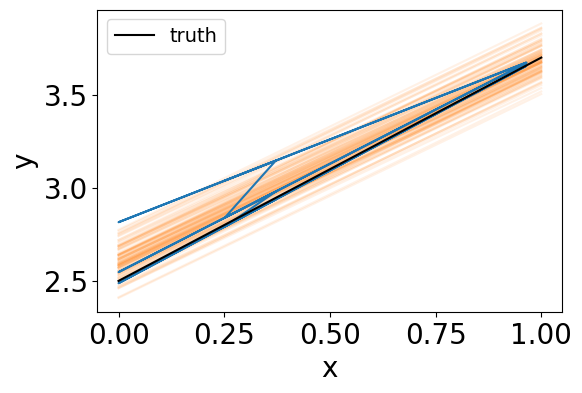

In [775]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    sigma = np.exp(sample[2])
    plt.plot(x_gt, ansatz(sample[:2], x_gt) + np.random.normal(0, sigma), "C1", alpha=0.1)
plt.plot(x, y)
plt.plot(x_gt, y_gt, "k", label="truth")
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

# Fit each simulation separately and look at their posteriors

Would we frame it as a mixture model / hierarchical model?

In [173]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2
    # sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    # sigma2 = np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [174]:
x = x_obs.copy()
ys = np.c_[y_obs].copy()

# ys += np.random.normal(0, 0.1, size=ys.shape)

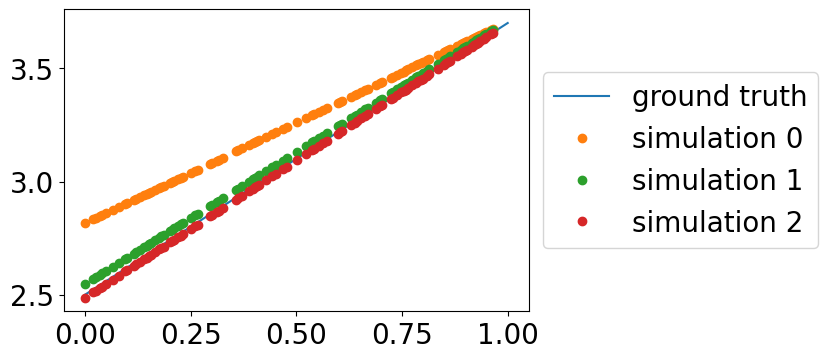

In [175]:
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_gt, y_gt, '-', label='ground truth')
for i, y in enumerate(ys):
    plt.plot(x, y, 'o', label=f'simulation {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [176]:
from scipy.optimize import curve_fit

In [177]:
f = lambda x, m, b: ansatz([m, b], x)
popts=[]
pcovs=[]
for y in ys:
    popt, pcov = curve_fit(f, x, y)
    popts.append(popt)
    pcovs.append(pcov)

In [178]:
popts

[array([0.88951777, 2.81529775]),
 array([1.16429113, 2.54700628]),
 array([1.21067317, 2.48750113])]

In [179]:
pcovs

[array([[ 0., -0.],
        [-0.,  0.]]),
 array([[ 0., -0.],
        [-0.,  0.]]),
 array([[ 0., -0.],
        [-0.,  0.]])]

In [180]:
import emcee

In [181]:
def run_emcee(pos, x, y, yerr):
    pos = np.concatenate([pos, [-2]]) + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x, y, yerr)
    )
    sampler.run_mcmc(pos, 10000, progress=True);
    return sampler

In [192]:
samplers=[]
for i in range(len(ys)):
    sampler = run_emcee(popts[i], x, ys[i], 0.1)
    # sampler = run_emcee(popts[i], x, ys[i], 0.001)
    # sampler = run_emcee(popts[i], x, ys[i], 2)
    samplers.append(sampler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2816.27it/s]


In [193]:
flat_samples_s = []
for sampler in samplers:
    flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
    flat_samples_s.append(flat_samples)
    print(flat_samples.shape)

(25600, 3)
(25600, 3)
(25600, 3)


In [194]:
import corner

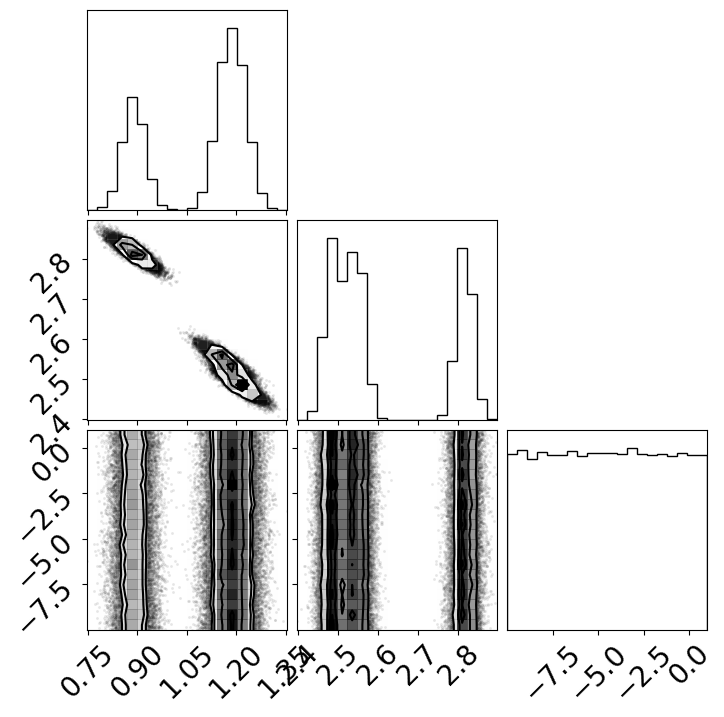

In [195]:
corner.corner(np.r_[flat_samples_s]);

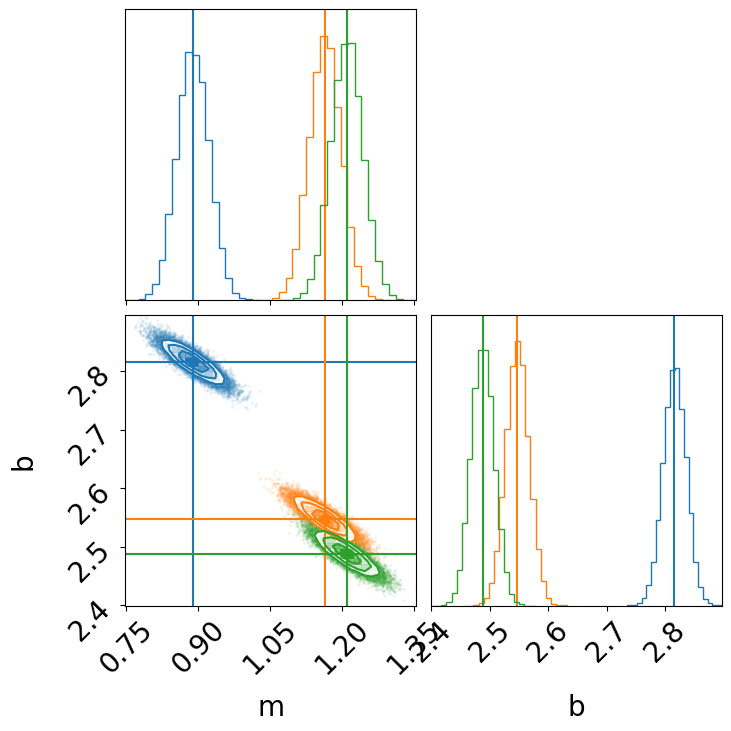

In [196]:

fig = plt.figure(figsize=(8,8))
fig = corner.corner(
    flat_samples_s[0][:,:2], labels=labels[:2], truths=[popts[0][0], popts[0][1]], color='C0', truth_color='C0', fig=fig,
);
corner.corner(
    flat_samples_s[1][:,:2], labels=labels[:2], truths=[popts[1][0], popts[1][1]], color='C1', truth_color='C1', fig=fig
);
corner.corner(
    flat_samples_s[2][:,:2], labels=labels[:2], truths=[popts[2][0], popts[2][1]], color='C2', truth_color='C2', fig=fig
);